# Assignment 2: Neural Networks for Digit Classification 

## Group Members Name:
- Ezekiel Ilori: 200589122
- Birva Pankajkumar Chudasama -200596766
- Kishan Dayanand Nishad - 200612579


## Importing the Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

## Dowloading the MNIST data and spliting the training and validation set into 80-20. normalize it to scale values from [0,255] to [0,1]

In [2]:
# Loading and Preprocessing MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trained_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='data', train=False, transform=transform, download=True)

train_dataset = trained_data.data.numpy()
test_dataset = test_data.data.numpy()

train_labels = trained_data.targets.numpy()
test_labels = test_data.targets.numpy()

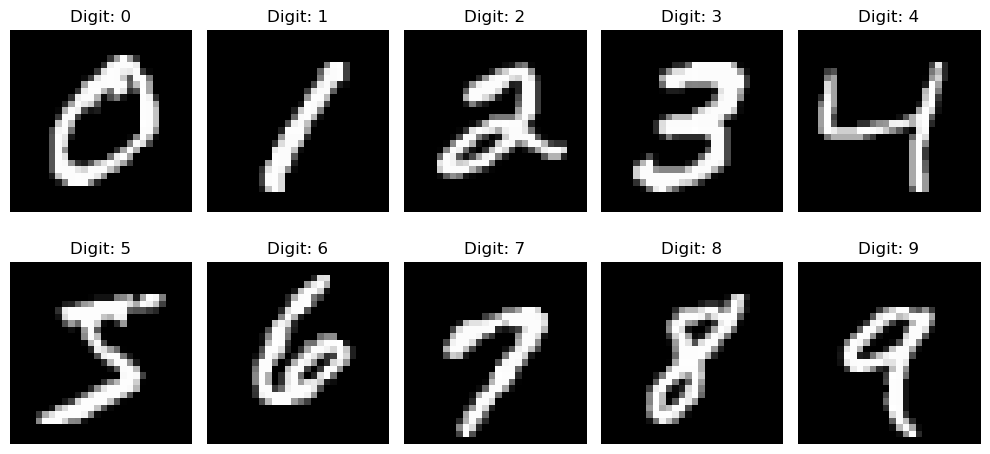

In [3]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    idx = np.where(train_labels == i)[0][0]
    plt.imshow(train_dataset[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Digit: {i}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

### Convert labels to tensors

In [4]:

train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)
    
train_dataset = torch.tensor(train_dataset.reshape(-1, 28 * 28), dtype=torch.float32) / 255
test_dataset = torch.tensor(test_dataset.reshape(-1, 28 * 28), dtype=torch.float32) / 255

train_dataset = TensorDataset(train_dataset, train_labels)
test_dataset = TensorDataset(test_dataset, test_labels)

# Split training set into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

### Dataloader for each dataset

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Define the model architecture with configurable layers

In [6]:

class NeuralNetwork(nn.Module):
    def __init__(self, layers=1):
        super(NeuralNetwork, self).__init__()
        self.layers = layers
        
        # Define layers based on input
        if layers == 1:
            self.model = nn.Sequential(
                nn.Linear(784, 128),
                nn.ReLU(),
                nn.Linear(128, 10),
                nn.Softmax(dim=1)
            )
        elif layers == 2:
            self.model = nn.Sequential(
                nn.Linear(784, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 10),
                nn.Softmax(dim=1)
            )
    
    def forward(self, x):
        return self.model(x)

### train_and_evaluate function

In [7]:
def train_and_evaluate(layers):
    model = NeuralNetwork(layers=layers)
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 10
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss, correct = 0, 0
        total = 0
        for images, labels in train_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(100. * correct / total)
        
        # Validation
        model.eval()
        val_epoch_loss, val_correct = 0, 0
        val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 28*28).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
        val_loss.append(val_epoch_loss / len(test_loader))
        val_acc.append(100. * val_correct / val_total)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, '
              f'Train Acc: {train_acc[-1]:.2f}%, Val Loss: {val_loss[-1]:.4f}, '
              f'Val Acc: {val_acc[-1]:.2f}%')
    return model, train_loss, val_loss, train_acc, val_acc


# Training the Models

In [8]:
# Training models for both configurations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train and evaluate model with 1 hidden layer
print("Training model with 1 hidden layer...")
model_1, train_loss_1, val_loss_1, train_acc_1, val_acc_1 = train_and_evaluate(layers=1)

# Train and evaluate model with 2 hidden layers
print("\nTraining model with 2 hidden layers...")
model_2, train_loss_2, val_loss_2, train_acc_2, val_acc_2 = train_and_evaluate(layers=2)

# Plotting training and validation metrics for each model separately
epochs = range(1, 11)

Training model with 1 hidden layer...
Epoch [1/10], Train Loss: 1.5924, Train Acc: 89.06%, Val Loss: 1.5358, Val Acc: 93.23%
Epoch [2/10], Train Loss: 1.5279, Train Acc: 93.92%, Val Loss: 1.5187, Val Acc: 94.59%
Epoch [3/10], Train Loss: 1.5123, Train Acc: 95.32%, Val Loss: 1.5097, Val Acc: 95.49%
Epoch [4/10], Train Loss: 1.5029, Train Acc: 96.12%, Val Loss: 1.5044, Val Acc: 95.97%
Epoch [5/10], Train Loss: 1.4968, Train Acc: 96.70%, Val Loss: 1.5020, Val Acc: 96.09%
Epoch [6/10], Train Loss: 1.4920, Train Acc: 97.15%, Val Loss: 1.4988, Val Acc: 96.43%
Epoch [7/10], Train Loss: 1.4884, Train Acc: 97.52%, Val Loss: 1.4938, Val Acc: 96.90%
Epoch [8/10], Train Loss: 1.4853, Train Acc: 97.79%, Val Loss: 1.4928, Val Acc: 96.94%
Epoch [9/10], Train Loss: 1.4827, Train Acc: 98.04%, Val Loss: 1.4927, Val Acc: 97.00%
Epoch [10/10], Train Loss: 1.4815, Train Acc: 98.13%, Val Loss: 1.4920, Val Acc: 97.00%

Training model with 2 hidden layers...
Epoch [1/10], Train Loss: 1.6031, Train Acc: 87.12%

# Ploting Graph and Metrics

In [9]:
def evaluate_model(model, title):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)])
    print(f"Classification Report for {title}:\n{report}")


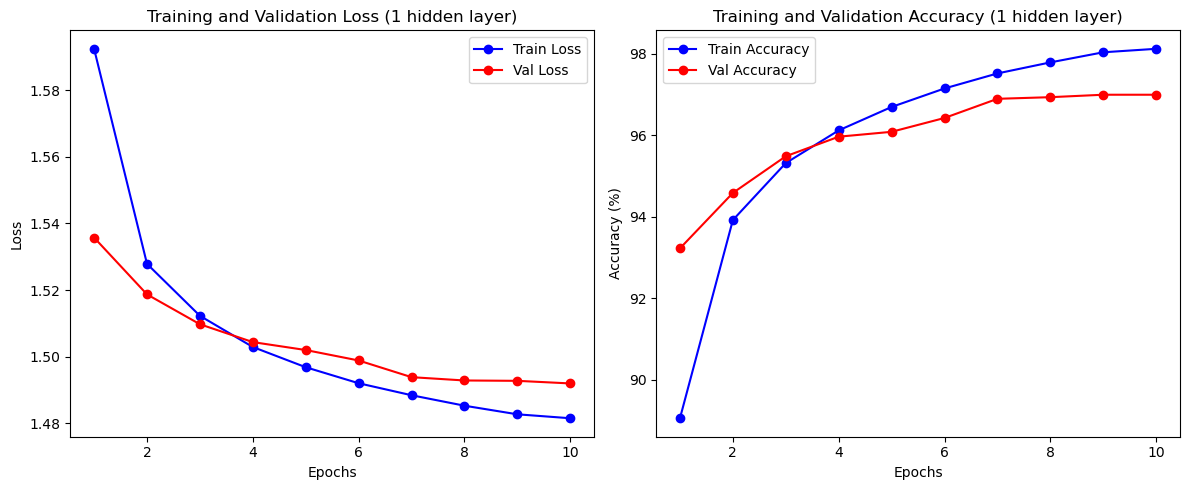

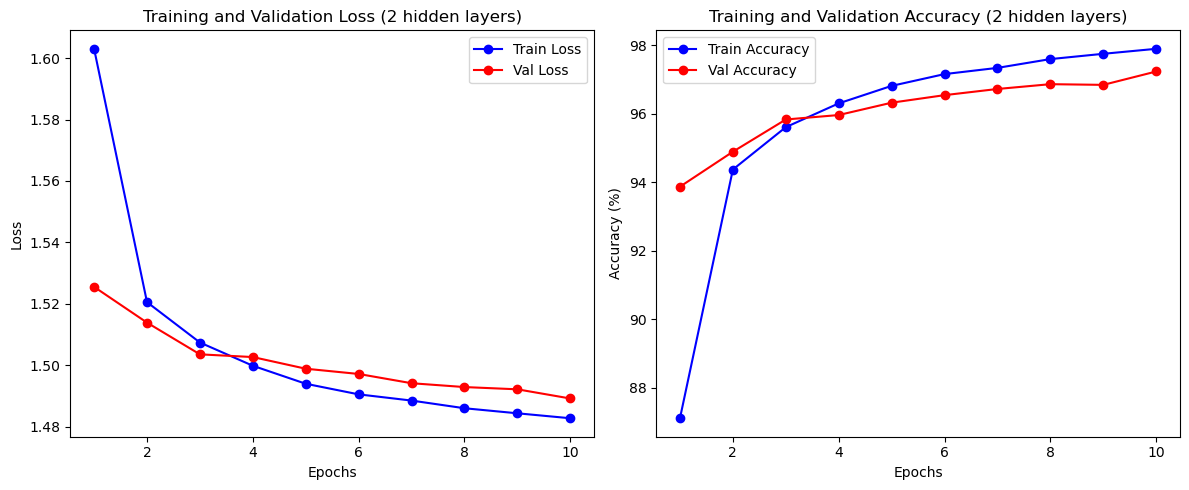

In [10]:
# Loss and accuracy plots for model with 1 hidden layer
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_1, 'bo-', label='Train Loss')
plt.plot(epochs, val_loss_1, 'ro-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (1 hidden layer)')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_1, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_acc_1, 'ro-', label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy (1 hidden layer)')
plt.tight_layout()
plt.show()

# Loss and accuracy plots for model with 2 hidden layers
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_2, 'bo-', label='Train Loss')
plt.plot(epochs, val_loss_2, 'ro-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (2 hidden layers)')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_2, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_acc_2, 'ro-', label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy (2 hidden layers)')
plt.tight_layout()
plt.show()

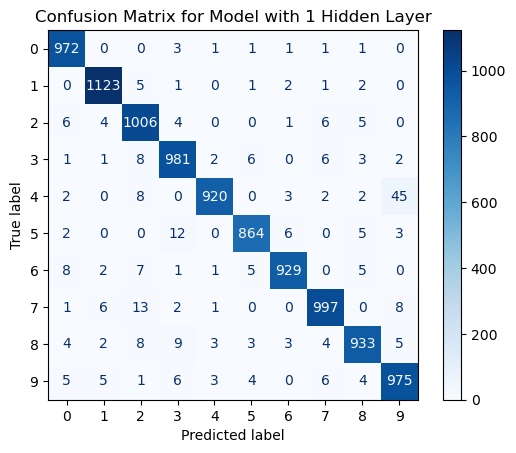

Classification Report for Confusion Matrix for Model with 1 Hidden Layer:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.96      0.97      0.97      1010
           4       0.99      0.94      0.96       982
           5       0.98      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.94      0.97      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



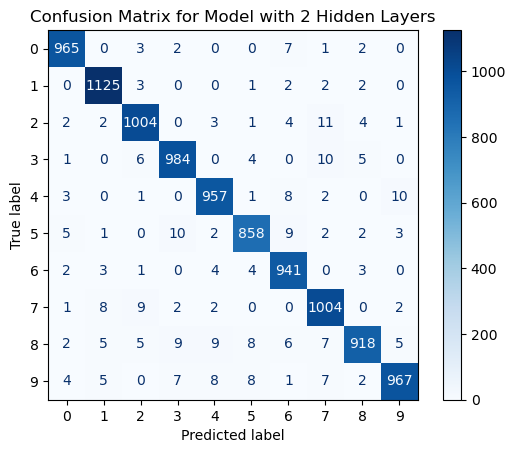

Classification Report for Confusion Matrix for Model with 2 Hidden Layers:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.96      0.98      0.97       958
           7       0.96      0.98      0.97      1028
           8       0.98      0.94      0.96       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [11]:
# Plot confusion matrix for model with 1 hidden layer
evaluate_model(model_1, "Confusion Matrix for Model with 1 Hidden Layer")

# Plot confusion matrix for model with 2 hidden layers
evaluate_model(model_2, "Confusion Matrix for Model with 2 Hidden Layers")